# Data Boycott and Data Strikes: Simulated Campaign Results

## Goals of this notebook
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts



In [193]:
import viz_constants 
import importlib

# slightly annoying reload hack
# see https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
importlib.reload(viz_constants)
(
    metric2title, group2scenario, num_users, num_ratings
) = (
    viz_constants.metric2title, viz_constants.group2scenario, 
    viz_constants.num_users, viz_constants.num_ratings
)

In [194]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt


for dataset in ['ml-20m', 'ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, ratio)

ml-20m 144.4135299257002
ml-1m 165.5975165562914


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [195]:
df_1m = pd.read_csv('ml-1m_collected_10_28/all_results.csv', dtype={'indices': str})
df_1m = df_1m[df_1m.ratingfrac.notna()]
df_1m['dataset'] = 'ml-1m'

In [196]:
df_20m = pd.read_csv('ml-20m_collected_11_01/all_results.csv', dtype={'indices': str})
df_20m = df_20m[df_20m.ratingfrac.notna()]
df_20m['dataset'] = 'ml-20m'

Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

In [197]:

for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    # Whoops! Assign doesn't work in a for loop.
#     df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
#     df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
#     df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'GlobalMean')
    with open(filename_ratingcv_standards, 'r') as f:
        global_mean_res = json.load(f)
        
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'SVD')
    with open(filename_ratingcv_standards, 'r') as f:
        svd_res = json.load(f)
        
    
    
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]
    try:
        for group in ['all', 'non-boycott']:
            #BAD: hard-coded constant, why?!?!?
#             df['loghits_' + group] = [np.log10(-1*(x - 89045.6)) for x in df['totalhits_' + group]]
#             df['standards_loghits_' + group] = [np.log10(-1 * (x - 89045.6)) for x in df['standards_totalhits_' + group]]
            #BAD: hard-coded constant, why?!?!?
            denom = (svd_res['hits'] / svd_res['normhits'] * num_users[dataset])
            print(svd_res['hits'], num_users[dataset], denom)
        
            df['biznormhits_' + group] = [x / denom for x in df['totalhits_' + group]]
            # if we want to make biz into its own group...
            # was deemed not too useful
            #df['normhits_' + 'biz' + group] = [x / denom for x in df['totalhits_' + group]]
            df['hitsbeyondrand_' + group] = [x - global_mean_res['totalhits'] for x in df['totalhits_' + group]]
    except KeyError as err:
        print('Skipping')
        print(err)
    

    # drop columns we're not going to use.
    drops = [
        #'tail',
        # 'vanilla',
    ]
    for column in df.columns.values:
        for drop in drops:
            if drop in column:
                df = df.drop(column, axis=1)

14.75632421589539 6040 117370.03696488823
14.75632421589539 6040 117370.03696488823
10.901500402382888 138493 2068444.9883455127
10.901500402382888 138493 2068444.9883455127


# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [198]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    #'tailndcg10',
    #'ndcg5',
    #'tailndcg5',
    #'ndcgfull',
    #'tailndcgfull',
    #'ndcgfull',
    'prec10t4',
    #'tailprec10t4',
    #'prec5t4',
    #'tailprec5t4',
    'hits',
    'totalhits',
    'normhits',
]

organized_experiments = [
    'gender', 'state', 'power', 'genre', 'occupation', 'age'
]
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'SVD', 
    'GlobalMean', 
    #'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]

# Flags
A variety of flags to turn various analyses on or off. Turning more flags off will make the notebook run faster.

In [199]:
flags = {}

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [200]:
dataset_to_algo_to_metric_to_altalgo = {}
ds2standards = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
    'ml-20m',
]:
    standard_results = {}
    algo2metric2altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = 0
                if metric == 'normhits':
                    
                    denom = (standard_results['SVD']['hits'] / standard_results['SVD']['normhits'] * num_users[dataset])
                    print(st_algo_name)
                    # since user isn't computed for 20m
                    if st_algo_name in standard_results:
                        standard_results[st_algo_name]['biz' + metric] = standard_results[st_algo_name].get('totalhits', 0) / denom
            if dataset == 'ml-20m':
                val = one_mill_svd.get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = 0
            
            
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo2metric2altalgo
    ds2standards[dataset] = standard_results
# pprint(dataset_to_algo_to_metric_to_altalgo)
pprint(ds2standards)

SVD
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd
File not found: standard_results/ml-20m_ratingcv_standards_for_KNNBasic_user_msd.json
SVD
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd
{'ml-1m': {'GlobalMean': {'avgest': 3.5815644532736712,
                          'avgest_frac': 1.0,
                          'avgrating': 3.702850090758313,
                          'avgrating_frac': 1.0,
                          'biznormhits': 0.6233072928304983,
                          'falsepos': 6.94329997055145,
                          'falsepos_frac': 1.0,
                          'hits': 12.123416107465065,
                          'hits_frac': 1.0,
                          'mae': 0.9338644598276286,
                          'ndcg10': 0.5913785077379672,
                          'ndcg10_frac': 0.7232870936361351,
                          'ndcg5': 0.5799281599099271,
                          'ndcg5_frac': 0.92599127688

                   'tailrec5t4': 0.5623463387163572,
                   'tailrec5t4_frac': 0.9584673730041586,
                   'tailtotalhits': 55619.2,
                   'tailtotalhits_frac': 1.0,
                   'totalhits': 89045.6,
                   'totalhits_frac': 1.0}},
 'ml-20m': {'GlobalMean': {'avgest': 3.5255285642989107,
                           'avgest_frac': 1.0,
                           'avgrating': 3.6271855577443737,
                           'avgrating_frac': 1.0,
                           'biznormhits': 0.5665988733582085,
                           'falsepos': 5.979031994475408,
                           'falsepos_frac': 1.0,
                           'hits': 8.472093298552625,
                           'hits_frac': 1.0,
                           'mae': 0.8408498561139182,
                           'ndcg10': 0.612647129606209,
                           'ndcg10_frac': 0.6321670812615489,
                           'ndcg5': 0.6011055526493165,
   

# Estimate change in "hits" based on precision or ndcg

For a given list of k-items, we assume users will click the items in that list that are "good" (rating over 4).


One way to do this is to follow this linear model:

* a user who gets a list with "full precision" (i.e. SVD w/ full data) provides 5 hits
* a user who gets a list with "un-personalized precision" (i.e. MovieMean) provides 5/ratio hits!
* note that in this case even users w/ bad lists still provide hits

Using these two points, we fit a line:


When ratio=1, recommender adds NO VALUE and therefore strikes do NO DAMAGE!

Anchor:hits

In [201]:
normalize_hits = False

for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]['SVD']
    # will only work for SVD as its written right now.
    
    #personalization_boost_coefficient
    for pbc in [
        1.1, 1.02, 2, 4, 8,
    ]:
        for old_metric, k in [
            ('prec10t4', 10),
            #('ndcg10', 10),
            # the actual count of 4 star ratings in the whole ds
            ('hits', 1),
            ('totalhits', 1),
            ('normhits', 1)
        ]:
            for group in ['non-boycott', 'all']:
                # name the new dataframe column
                new_metric = '{}boosthits-{}'.format(pbc, old_metric)
                total_possible_hits = num_users[dataset] * k
                if old_metric == 'totalhits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric]
                elif old_metric == 'hits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric] * num_users[dataset]
                
                # boycotting users provide 0 hits. 
                # so with a full boycott, damage = total possible hits
                comparison = -1 * total_possible_hits
                #comparison = -1 * ds2standards[dataset]['SVD'][old_metric] * total_possible_hits

                key_template = 'percent_increase_{}_{}'
                new_key = key_template.format(new_metric, group)

   
                # no missing users in a strike ("All Users" perspective)
                if group == 'all':
                    frac_miss_arr = [0] * len(df.index)
                # there are missing users in a data boycott!
                else:
                    frac_miss_arr = list(df['num_users_boycotting'])

                labor_metric = 'labor-' + new_metric
                consumer_metric = 'consumer-' + new_metric

                # get the predicted diff if we switched to MovieMean
                pred_diff = metric2altalgo[old_metric]['MovieMean']
                # should get more negative as prec_val gets more negative
                #print(pred_diff)
                coefficients = np.polyfit(
                    [pred_diff, 0], # x values
                    [total_possible_hits/pbc - total_possible_hits, 0],# y values
                    1, # polynomial order, i.e. this is a line
                )

                df[key_template.format(labor_metric, group)] = [
                    ( coefficients[1] + coefficients[0] * prec_val  * (1 - frac_miss)) for (
                        prec_val, frac_miss
                    ) in zip(df[key_template.format(old_metric, group)], frac_miss_arr)
                ]
                df[key_template.format(consumer_metric, group)] = [
                    (comparison * frac_miss) for frac_miss in frac_miss_arr
                ]

                df[new_key] = [
                    (labor_power + consumer_power) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]
                df[new_key.replace('percent_increase_', '')] = [
                    (labor_power + consumer_power + ds2standards[dataset]['SVD']['totalhits']) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]

                if normalize_hits:
                    print('Normalizing. Will divide hit values by total possible hits.')
                    df[new_key] /= total_possible_hits
                    df[key_template.format(labor_metric, group)] /= total_possible_hits
                    df[key_template.format(consumer_metric, group)] /= total_possible_hits

                for st_al_nm in standard_algo_names:
                    old_val = metric2altalgo[old_metric][st_al_nm]
                    # convert from percent to raw precision change
                    old_val *= ds2standards[dataset]['SVD'][old_metric] / 100
                    # multiply by k and the probability of clicks b/c we want to get from prec@5 to hits
                    if not normalize_hits:
                        old_val *= total_possible_hits
                    metric2altalgo[new_metric][st_al_nm] = old_val
                    metric2altalgo[labor_metric][st_al_nm] = old_val
                    metric2altalgo[consumer_metric][st_al_nm] = old_val
            df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            df['increase_hit-ratio@{}_all'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            #print(df[['num_users_boycotting', 'increase_hits-prec5t4_non-boycott', 'increase_hits-prec5t4_all', 'increase_hit-ratio@5_non-boycott']])


## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts.

In [202]:
samples_df_20m = df_20m[df_20m['type'] == 'sample_users']
print('\n===Heterogenous 20M Boycotts===\n')
print(samples_df_20m.name.value_counts())
samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())


===Heterogenous 20M Boycotts===

69 user sample        30
14 user sample        30
138 user sample       30
96945 user sample     20
55397 user sample     20
69246 user sample     20
137108 user sample    20
110794 user sample    20
124644 user sample    20
1385 user sample      20
41548 user sample     20
13849 user sample     20
692 user sample       20
83096 user sample     20
6925 user sample      20
27699 user sample     10
Name: name, dtype: int64

===Heterogenous Boycotts===

3624 user sample    250
5980 user sample    250
4228 user sample    250
2416 user sample    250
60 user sample      250
1 user sample       250
604 user sample     250
3020 user sample    250
302 user sample     250
4832 user sample    250
5436 user sample    250
1208 user sample    250
30 user sample      250
6 user sample       250
3 user sample       250
1812 user sample    250
Name: name, dtype: int64

===Homogenous Boycotts===

Fans of Fantasy excluded using threshold 4        20
male users excluded  

# Compare Precision-Estimated Hits to Actual Hits


   num_users_boycotting    variable     value
0                   0.2  ndcg10_all  0.787265
1                   0.2  ndcg10_all  0.787250
2                   0.2  ndcg10_all  0.785957
3                   0.2  ndcg10_all  0.786934
4                   0.2  ndcg10_all  0.785387


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


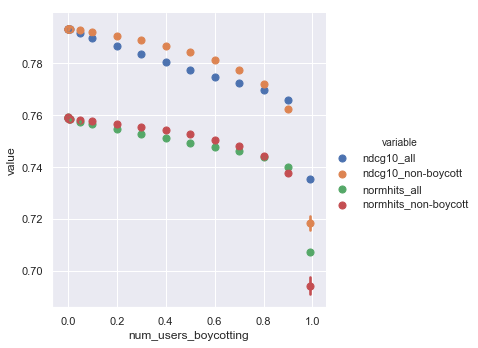

In [206]:
hits_df = samples_df_1m.copy()
hits_df = hits_df[~hits_df.hits_all.isna()]
hits_metric = 'ndcg10'
metric2 = 'normhits'
include = [
    'num_users_boycotting', 
]
hits_cols = [
    '{}_all'.format(hits_metric), 
    '{}_non-boycott'.format(hits_metric),
    #'{}_boycott'.format(hits_metric),
]
# for col in hits_cols:
#     hits_df[col] *= 0.76 / 14.75#num_users['ml-1m']

plot_metric2 = True
include += hits_cols
if plot_metric2:
    cols = [
        '{}_all'.format(metric2), 
        '{}_non-boycott'.format(metric2),
    ]

    include += cols
    
hits_df = hits_df[include].melt(id_vars='num_users_boycotting')
print(hits_df.head())

# for k in hits_df.num_users_boycotting:
#     print(k)
#     matches_from_hits = hits_df[hits_df.num_users_boycotting == k]
#     matches_from_orig = samples_df_1m[hits_df.num_users_boycotting == k]

sns.lmplot(
        x="num_users_boycotting", y="value", hue='variable', data=hits_df,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
    )
plt.show()

In [207]:
from collections import defaultdict
name2vals = defaultdict(list)

for name, group in hits_df.groupby('num_users_boycotting'):
    #print(name)
    for subname, subgroup in group.groupby('variable'):
        #print(subname, subgroup['value'].mean())
        name2vals[subname].append(subgroup['value'].mean())
        
print(name2vals)

defaultdict(<class 'list'>, {'ndcg10_all': [0.7931250310896443, 0.7932713480025121, 0.7933384022023857, 0.7933118726742144, 0.7931513379318039, 0.7916711566486403, 0.7899893463109552, 0.7866861150073696, 0.7835196822674622, 0.7805176549803142, 0.7776396328406548, 0.7749214288544028, 0.7723996797486925, 0.7696992468304245, 0.7658600080020406, 0.7354183693266847], 'ndcg10_non-boycott': [0.7931275276641484, 0.7932797634204442, 0.7933561219656592, 0.7934163494733748, 0.793370163372054, 0.7927533890869488, 0.79205360787687, 0.7905728712441638, 0.7889011616093675, 0.7868481634529079, 0.7842452463726403, 0.7812693033980893, 0.7774655702733646, 0.7719522481723987, 0.7625499535674835, 0.7182904912395457], 'normhits_all': [0.7591481177386741, 0.7590574816292169, 0.7588924310552186, 0.7585775032894058, 0.758432497789692, 0.7575709076012412, 0.7565830980270858, 0.7547139516992252, 0.7527810822611931, 0.7510419907082321, 0.7493408319453282, 0.7476833966064055, 0.7460579473660366, 0.7439874267753422

ndcg10_all normhits_all
(0.9842313247370235, 6.235479069629971e-12)
ndcg10_non-boycott normhits_non-boycott
(0.9949798764930259, 2.1262252636775034e-15)


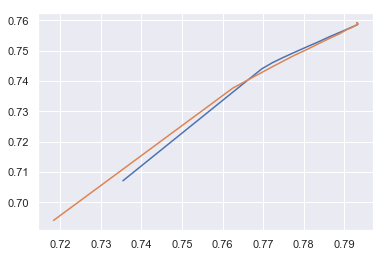

In [208]:
from scipy.stats import pearsonr

try:
    for group in [
        'all', 'non-boycott',
    ]:
        x = '{}_{}'.format(hits_metric,group)
        y = '{}_{}'.format(metric2, group)
        print(x, y)
        print(pearsonr(name2vals[x], name2vals[y]))
        plt.plot(name2vals[x], name2vals[y])
    plt.show()
except Exception as err:
    print(err)
    pass

In [209]:
# bonus
if False:
    metric = 'ndcgfull_non-boycott'
    print('1...')
    name = '1 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('3...')
    name = '3 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('6')
    name = '6 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('30')
    name = '30 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots too confusing.

In [210]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Data Manipulating Helpers
In the following two cells, we define two functions (`select_cols` and `fill_in_longform`) that will help with general purpose manipulating of our result data.

In [211]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

metrics ['biznormhits']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:biznormhits  |  #users:0.3
NB Val:0.5285404895847312  |  ALL val:0.7517548897628394
Metric biznormhits has no MovieMean comparison.
{'value': 0.7449022106566673, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.6233072928304983, 'color': '0.3', 'name': 'GlobalMean', 'linestyle': '-'}
{'value': 0.7586740389852513, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
{'value': 0.7449022106566673, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.6233072928304983, 'color': '0.3', 'name': 'GlobalMean', 'linestyle': '-'}
{'value': 0.7586740389852513, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.5285404895847312}})


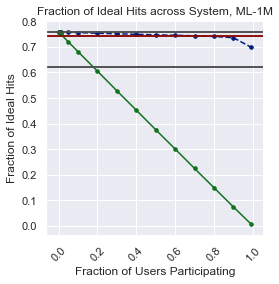

In [212]:
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'biznormhits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Fraction of Ideal Hits',
    title_template='{}, {}',
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_biznormhits.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['biznormhits']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'value': 0.6967486242661748, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.5665988733582085, 'color': '0.3', 'name': 'GlobalMean', 'linestyle': '-'}
{'value': 0.7290733901539449, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
{'value': 0.6967486242661748, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.5665988733582085, 'color': '0.3', 'name': 'GlobalMean', 'linestyle': '-'}
{'value': 0.7290733901539449, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}


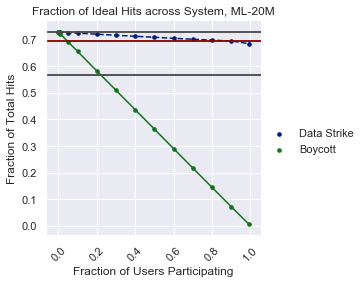

In [213]:
df, ds = samples_df_20m, 'ml-20m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'biznormhits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=True, 
    ylabel='Fraction of Total Hits',
    title_template='{}, {}',
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'GlobalMean'], #line_names=['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=False,
    #ylim=(0.6, 0.8)
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
plt.savefig(ds + '_biznormhits.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['normhits']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:normhits  |  #users:0.3
NB Val:0.7555350933826405  |  ALL val:0.7527810822611931
ratio_nb: -0.4782437581073191  |  ratio_all:-0.4765005053582065
{'value': 0.747381042144004, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.7593777813214053, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
{'value': 0.7527858189100051, 'color': 'r', 'name': 'Item KNN (1999)', 'linestyle': ':'}
{'value': 0.7552851991335546, 'color': 'y', 'name': 'Item KNN + Baselines: 2010', 'linestyle': ':'}
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7555350933826405}})


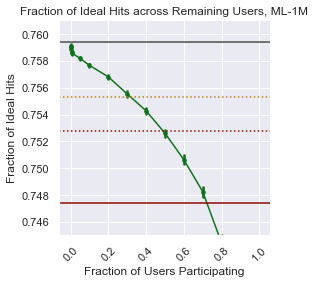

In [93]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'normhits',
    ],
    groups=[
        'non-boycott', 
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    ylim=(0.745, 0.761),
    #ylim=(0.752, 0.753),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['normhits', 'ndcg10']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:normhits  |  #users:0.3
NB Val:-0.5097283023344503  |  ALL val:-0.8686979290773396
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.5952406617614797  |  ALL val:-1.259723247573784
{'value': -2.594307467586317, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.0, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
{'value': -0.8485203180589312, 'color': 'r', 'name': 'Item KNN (1999)', 'linestyle': ':'}
{'value': -0.33192023134976895, 'color': 'y', 'name': 'Item KNN + Baselines: 2010', 'linestyle': ':'}
{'value': -1.5798117185527312, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.0, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
{'value': -0.8680741751397408, 'color': 'r', 'name': 'Item KNN (1999)', 'linestyle': ':'}
{'value': -0.5389388903016261, 'color': 'y', 'name': 'Item KNN + Baselines: 2010', 'linestyle': ':'}
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.5524844820479651}})


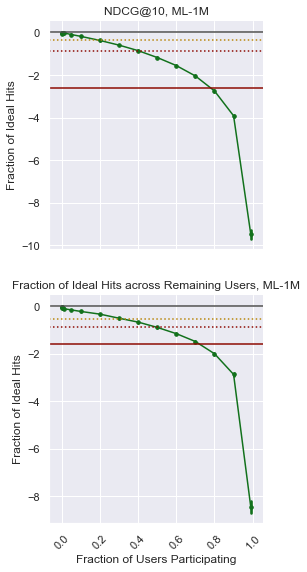

In [223]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_1m, 'ml-1m'

algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        'normhits',
        'ndcg10'
    ],
    groups=[
        'non-boycott', 
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['normhits']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:normhits  |  #users:0.3
NB Val:0.7282467848272225  |  ALL val:nan
ratio_nb: -0.17225266820263854  |  ratio_all:nan
{'value': 0.6990522969095772, 'color': 'r', 'name': 'MovieMean', 'linestyle': '-'}
{'value': 0.7299113603378171, 'color': '0.3', 'name': 'SVD', 'linestyle': '-'}
{'value': 0.7183220885199246, 'color': 'r', 'name': 'Item KNN (1999)', 'linestyle': ':'}
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7282467848272225}})


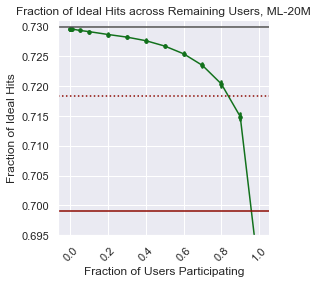

In [224]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_20m, 'ml-20m'

twenty_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'normhits',
    ],
    groups=[
        'non-boycott', 
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    ylim=(0.695, 0.731),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

In [225]:
pinks = {}
pinks[2] = '#f8bbd0'
pinks[3] = '#f48fb1'
pinks[4] = '#f06292'
pinks[5] = '#ec407a'
pinks[6] = '#e91e63'
pinks[7] = '#d81b60'

purples = {}
purples[2] = '#e1bee7'
purples[3] = '#ce93d8'
purples[4] = '#ba68c8'
purples[5] = '#ab47bc'
purples[6] = '#9c27b0'
purples[7] = '#8e24aa'
#https://material.io/tools/color/#!/?view.left=0&view.right=0&primary.color=E1BEE7

### Look at totalhits

metrics ['1.02boosthits-totalhits', '1.1boosthits-totalhits', '2boosthits-totalhits', '4boosthits-totalhits', '8boosthits-totalhits', 'labor-1.02boosthits-totalhits', 'labor-1.1boosthits-totalhits', 'labor-2boosthits-totalhits', 'labor-4boosthits-totalhits', 'labor-8boosthits-totalhits', 'consumer-1.1boosthits-totalhits']
algo_name


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'name': 'MaxDamage', 'linestyle': '-'}
{'value': -114000, 'color': '0.3', 'na

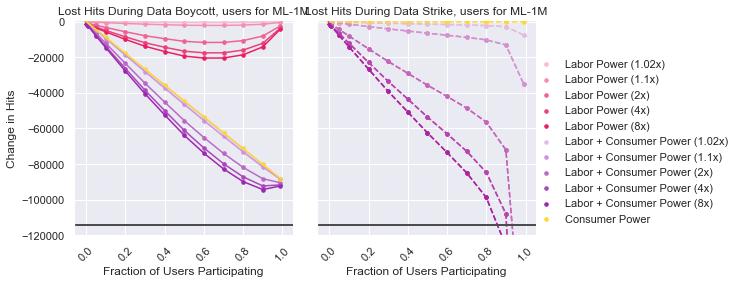

In [226]:
metric = 'totalhits'
_ = plot(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo['ml-1m'],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()

In [227]:
metric = 'totalhits'
df = samples_df_20m
ds = 'ml-20m'
_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], 
    #ylim=(-120000, 500),
    print_vals=None
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_complicatedhits.svg', bbox_inches='tight', dpi=300)
plt.show()

TypeError: 'module' object is not callable

In [ ]:

# _ = p_b_curve(
#     samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
#     show_interp=False,
#     increase=True,percents=True, normalize=True,
#     metrics=['ndcg10',],
#     groups=['non-boycott', 'all', ],
#     legend=False,
#     ylabel='nDCG@10 personalization factor',
#     height=4,
#     line_names=[
#         'Zero', 'KNNBasic_item_msd', 
#         #'KNNBaseline_item_msd', 'KNNBasic_user_msd', 
#         'MovieMean']
# )
# plt.ylim(-1.2, 0.05)
# plt.savefig('ml-1m_ndcg_curve.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# #Anchor: OLD Paper Figure
# _ = p_b_curve(
#     samples_df_20m, 'ml-20m',
#     show_interp=False,
#     increase=True, percents=True, normalize=True,
#     metrics=['ndcg10'],
#     groups=['non-boycott', 'all', ], 
#     height=4, aspect=1,
#     line_names=['Zero', 'KNNBasic_item_msd', 
#                 #'KNNBaseline_item_msd', 
#                 '1M_SVD', 'MovieMean']
# )
# #plt.ylim(-1.2, 0.05)
# plt.savefig('ml-20_ndcg_curve.png', bbox_inches='tight', dpi=300)
# plt.show()

# Bunch of Metrics for all Groups, don't save

In [ ]:
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    percents=True, normalize=True,
    metrics=['ndcg10', 'prec10t4', 'rmse'],
    groups=['non-boycott', 'all', 'boycott'],
    legend=False,
    ylabel='nDCG@10 personalization factor',
    height=4,
    palette=None,
)
#plt.ylim(-1.2, 0.05)
plt.show()

## Find intersection of the non-boycott curve with horizontal lines

In [ ]:
metric = 'normhits'
comparisons = ds2standards['ml-1m']
comparisons = {
    key: comparisons[key].get(metric, 0) for key in comparisons.keys()
}
movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean']
for group in [
    #'all', 
    'non-boycott'
]:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)):
        y = algo_to_metric_to_group_to['SVD'][metric][group]['interp_ratings'](x)
        #print(y)
        #print(comparisons['KNNBaseline_item_msd'])
        #print(x, y)
        if not found_item:
            if y <= comparisons['KNNBaseline_item_msd']:
                print(group + ' found item:')
                print(x / num_ratings['ml-1m'])
                found_item = True
        if not found_user:
            if y <= comparisons['KNNBasic_user_msd']:
                print(group + ' found user')
                print(x / num_ratings['ml-1m'])
                found_user = True
        if not found_itembasic:
            if y <= comparisons['KNNBasic_item_msd']:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['ml-1m'])
                found_itembasic = True

In [ ]:
# d = {}
# group = 'non-boycott'
# print(group)
# d['30_1m'] = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100
# d['30_20m'] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100
# print(d)

# group = 'all'
# print(group)
# d['30_1m'] = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100
# d['30_20m'] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100
# print(d)

In [ ]:
# d = {}
# d[19] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.19 * num_ratings['ml-20m']) * 100
# d[44] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.44 * num_ratings['ml-20m']) * 100
# print(d)

In [ ]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [ ]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [ ]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [244]:
NORMALIZE = False

#metrics += ['hits-prec5t4', 'labor-hits-prec5t4', 'consumer-hits-prec5t4']

metrics = [
    'ndcg10', 
]

normed_org_df = org_df.copy()
if NORMALIZE:
    for metric in metrics:
        for algo_name in algo_names:
            movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
            for group in ['non-boycott', 'like-boycott']:
                col = 'percent_increase_{}_{}'.format(metric, group)

                normed_org_df.loc[
                    normed_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = 'percent_increase_{}_expected'.format(metric)
    for i, row in normed_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    normed_org_df = normed_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [245]:
from p_b_curve import select_cols, fill_in_longform
ylabel = 'ylabel'

def plot2(
        df, metrics, groups,
        increase=False, percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
#        tmp = df[df.name == name].num_ratings_missing.mean()
        tmp = df[df.name == name].num_users_boycotting.mean()
        print('Num users boycottng: {}. As a percent: {}'.format(tmp, tmp*100))
#         print('name', name)
#         print('mean number of ratings missing', tmp)pl
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, increase=increase, percents=percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
#     for metric in metrics:
#         for col in increase_cols:
#             if metric in col and 'expected' in col:
#                 expec = col
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
                elif 'like-boycott' in col:
                    lb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                lb_arr = np.array(masked[masked.increase_type == lb].value)
                
                expec_mean = np.mean(expec_arr)
                nb_mean = np.mean(nb_arr)
                lb_mean = np.nanmean(lb_arr)
                
                ratio = nb_mean / expec_mean
                diff = nb_mean - expec_mean
                lb_diff = lb_mean - nb_mean
                lb_ratio = lb_mean / expec_mean

                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                print('LB to NB: {}'.format(lb_diff / diff))
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff > 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Similar Users', 'Not Participating\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(ylabel)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios)


In [246]:
normed_org_df = normed_org_df[normed_org_df.algo_name == 'SVD']

In [247]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']

In [248]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c'}

def plot_all_three_scenarios(df, height=6):

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios) = plot2(
            half_users_df,
            metrics=metrics,
            increase=True, percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios)

In [249]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_ratios = {
    'lb': {},
    'nb': {}
}

# Make plots for paper here.

len of df (number of experiments included) 80
Num users boycottng: 0.3586092715231787. As a percent: 35.86092715231787
Num users boycottng: 0.05000000000000001. As a percent: 5.000000000000001
Num users boycottng: 0.14139072847682116. As a percent: 14.139072847682115
Num users boycottng: 0.023841059602648998. As a percent: 2.3841059602649


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


local variable 'expec' referenced before assignment
SVD normhits
local variable 'expec' referenced before assignment
SVD normhits
local variable 'expec' referenced before assignment
SVD normhits
local variable 'expec' referenced before assignment
SVD normhits
Totals:
0 lbless, 0 sig, 0 less, and 0 more out of 0 total


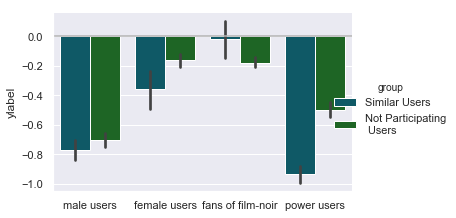

In [250]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('film-noir')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=['normhits'],
    increase=True, percents=True,
    groups=['non-boycott', 'like-boycott', 'expected'],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=True,
    palette=palette,
    aspect=1.5
)

plt.show()

## Male User and Female User Boycotts

len of df (number of experiments included) 40
Num users boycottng: 0.3586092715231787. As a percent: 35.86092715231787
Num users boycottng: 0.14139072847682116. As a percent: 14.139072847682115


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.416046271169951, pval: 2.3208539815383296e-20
LB to NB: -0.13985767490218956
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.3227612178785923, pval: 5.011861270257513e-15
LB to NB: -0.5059147142891406
Totals:
2 lbless, 2 sig, 2 less, and 0 more out of 2 total
total2 2 2


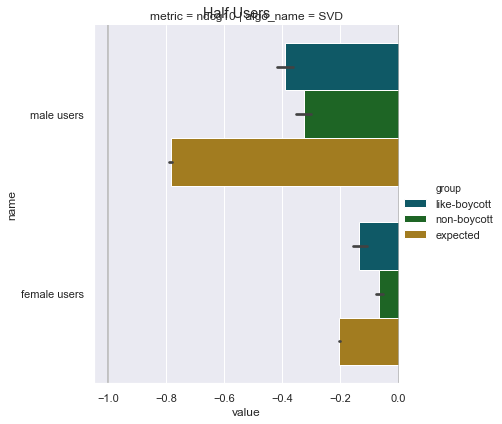

In [235]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

len of df (number of experiments included) 40
Num users boycottng: 0.05000000000000001. As a percent: 5.000000000000001
Num users boycottng: 0.05132450331125828. As a percent: 5.132450331125828


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD power users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.7625843867947112, pval: 2.966960418991537e-09
LB to NB: -2.452237819447548
ndcg10 SVD bottom 10% contributors, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.033673305554852, pval: 5.210666675684726e-06
LB to NB: -31.076685823007494
Totals:
2 lbless, 2 sig, 2 less, and 0 more out of 2 total
total2 2 2


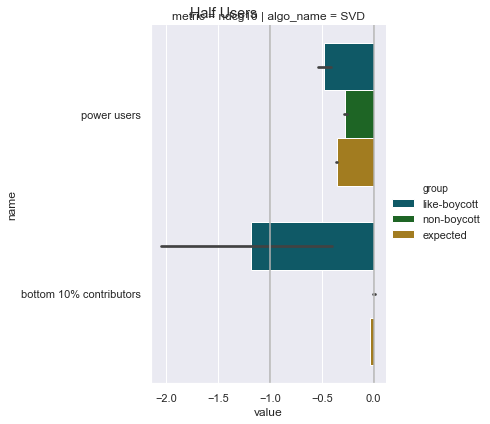

In [236]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])


plt.show()

# Age Boycotts

len of df (number of experiments included) 140
Num users boycottng: 0.09867549668874175. As a percent: 9.867549668874174
Num users boycottng: 0.04552980132450332. As a percent: 4.552980132450332
Num users boycottng: 0.17350993377483445. As a percent: 17.350993377483444
Num users boycottng: 0.03145695364238411. As a percent: 3.145695364238411
Num users boycottng: 0.09139072847682118. As a percent: 9.139072847682119
Num users boycottng: 0.04105960264900663. As a percent: 4.105960264900663
Num users boycottng: 0.018377483443708605. As a percent: 1.8377483443708604


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD 35-44, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.3992167050142747, pval: 2.393730733835746e-13
LB to NB: -0.4937443041321756
ndcg10 SVD 45-49, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.4560015298916725, pval: 7.492080164308318e-07
LB to NB: -2.7043601125203836
ndcg10 SVD 25-34, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.42978419442322074, pval: 1.1101886505142967e-16
LB to NB: -0.1542284214361964
ndcg10 SVD 56+, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.07567682173353825, pval: 2.9248063280726862e-05
LB to NB: -2.400286854331561
ndcg10 SVD 18-24, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.5122273324275355, pval: 3.316259124060115e-10
LB to NB: -0.8736483954553765
ndcg10 SVD 50-55, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.3922815442885304, pval: 1.32727038228

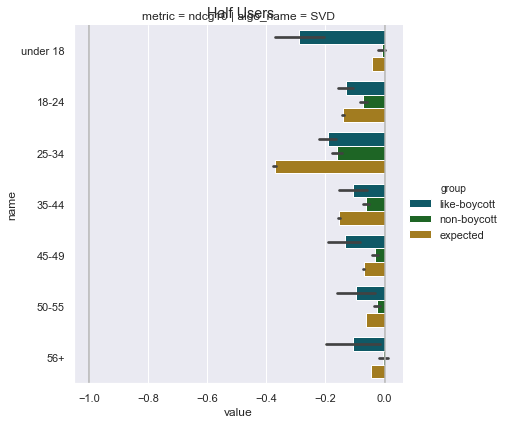

In [237]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()


# Occupation Boycotts

len of df (number of experiments included) 420
Num users boycottng: 0.005794701986754968. As a percent: 0.5794701986754968
Num users boycottng: 0.009271523178807946. As a percent: 0.9271523178807947
Num users boycottng: 0.0013245033112582777. As a percent: 0.13245033112582777
Num users boycottng: 0.02317880794701987. As a percent: 2.317880794701987
Num users boycottng: 0.03211920529801325. As a percent: 3.211920529801325
Num users boycottng: 0.011920529801324499. As a percent: 1.19205298013245
Num users boycottng: 0.014238410596026489. As a percent: 1.423841059602649
Num users boycottng: 0.016225165562913906. As a percent: 1.6225165562913906
Num users boycottng: 0.025000000000000005. As a percent: 2.5000000000000004
Num users boycottng: 0.056291390728476796. As a percent: 5.629139072847679
Num users boycottng: 0.011754966887417222. As a percent: 1.1754966887417222
Num users boycottng: 0.02218543046357617. As a percent: 2.218543046357617
Num users boycottng: 0.06291390728476821. As a pe

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD tradesman/craftsman, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.13898432102504213, pval: 8.951504396478111e-06
LB to NB: 3.2528185187728047
ndcg10 SVD customer service, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.08401083506964516, pval: 5.856344383505223e-08
LB to NB: -12.224787379228031
ndcg10 SVD farmer, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.47786203607874794, pval: 0.013150587330994027
LB to NB: -25.6542216832757
ndcg10 SVD writer, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.43791415049279003, pval: 4.133821473312107e-05
LB to NB: 1.759553791727717
ndcg10 SVD programmer, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.4990493163087999, pval: 0.0008433053618499202
LB to NB: 1.5271747484376688
ndcg10 SVD scientist, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.25518

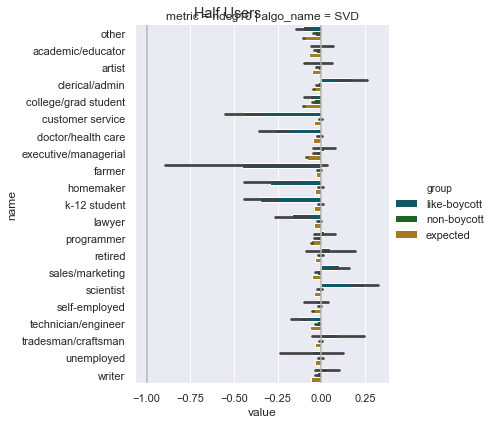

In [238]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
plt.show()

# Genre Boycotts

len of df (number of experiments included) 360
Num users boycottng: 0.08311258278145696. As a percent: 8.311258278145695
Num users boycottng: 0.011589403973509936. As a percent: 1.1589403973509935
Num users boycottng: 0.06821192052980131. As a percent: 6.821192052980131
Num users boycottng: 0.028145695364238398. As a percent: 2.8145695364238397
Num users boycottng: 0.16953642384105955. As a percent: 16.953642384105954
Num users boycottng: 0.053311258278145666. As a percent: 5.331125827814566
Num users boycottng: 0.059271523178807926. As a percent: 5.927152317880792
Num users boycottng: 0.026986754966887412. As a percent: 2.6986754966887414
Num users boycottng: 0.030960264900662247. As a percent: 3.0960264900662247
Num users boycottng: 0.050993377483443694. As a percent: 5.09933774834437
Num users boycottng: 0.031125827814569528. As a percent: 3.1125827814569527
Num users boycottng: 0.011589403973509936. As a percent: 1.1589403973509935
Num users boycottng: 0.007284768211920532. As a pe

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD fans of war, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.4360536816860687, pval: 1.3519408652347787e-16
LB to NB: -0.3847687249859609
ndcg10 SVD fans of fantasy, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.22833713973654177, pval: 3.071830117486562e-05
LB to NB: -1.7237845675079297
ndcg10 SVD fans of romance, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.40744557550884547, pval: 7.494183511184757e-09
LB to NB: -0.9958179029426164
ndcg10 SVD fans of children's, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.3483090576003361, pval: 1.086143230923705e-07
LB to NB: -1.9815642195794492
ndcg10 SVD fans of drama, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.20408357398383367, pval: 7.412474811962885e-16
LB to NB: -0.18109449845376646
ndcg10 SVD fans of sci-fi, percent_increase_ndcg10_expected, percent_increase_ndcg1

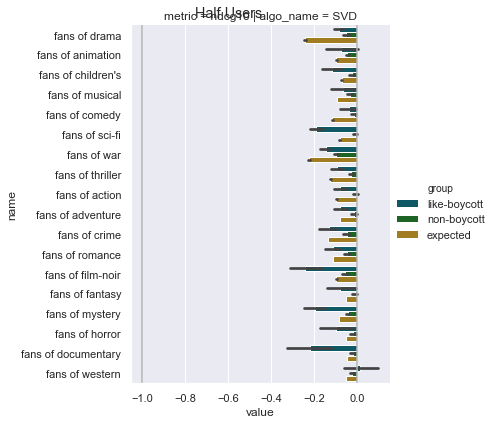

In [239]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()

In [240]:
running_totals

{'total': 50,
 'total_lbless': 40,
 'total_less': 50,
 'total_more': 0,
 'total_sig': 50}

In [241]:
from pprint import pprint
pprint(all_diffs)
pprint(all_ratios)

{'lb': {'18-24': -0.059909585604982746,
        '25-34': -0.03271678827224922,
        '35-44': -0.045672395271146186,
        '45-49': -0.10327163898316707,
        '50-55': -0.07263386558452206,
        '56+': -0.10340246380835706,
        'academic/educator': 0.03340439943762177,
        'artist': -0.002096086872025279,
        'bottom 10% contributors': -1.1798424004527124,
        'clerical/admin': 0.18694909407616597,
        'college/grad student': -0.023120826603580863,
        'customer service': -0.44097568656702174,
        'doctor/health care': -0.2503367355007612,
        'executive/managerial': 0.045304655991203285,
        'fans of action': -0.07110385208579342,
        'fans of adventure': -0.06448730351608387,
        'fans of animation': -0.02797761914064919,
        "fans of children's": -0.09291020820718879,
        'fans of comedy': -0.02350520486621471,
        'fans of crime': -0.08395695407805867,
        'fans of documentary': -0.19996945200314,
        'fans o

In [242]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)

# Back of the napkin

In [243]:

# non-boycott
# {'30_1m': -23.058666562695052, '30_20m': -2.8121875718078724}
# all
# {'30_1m': -49.3478951742734, '30_20m': -34.76984903171993}
boycott_size =0.3

strike_effects = {
    '1m': 0.493,
    '20m': 0.348,
}

boycott_effects = {
    '1m': 0.23,
    '20m': 0.028,
}
views_from_rec = 0.3

total_effects = {
    'strike': {},
    'boycott': {},
    'ratio': {},
}

# ds for dataset!
for ds in ['1m', '20m']:
    total_effects['boycott'][ds] = (1 - boycott_size) * boycott_effects[ds] * views_from_rec + boycott_size
    total_effects['strike'][ds] = 1 * strike_effects[ds] * views_from_rec
    total_effects['ratio'][ds] = total_effects['boycott'][ds] / total_effects['strike'][ds]


from pprint import pprint
pprint(total_effects)

{'boycott': {'1m': 0.3483, '20m': 0.30588},
 'ratio': {'1m': 2.3549695740365113, '20m': 2.9298850574712643},
 'strike': {'1m': 0.1479, '20m': 0.10439999999999999}}
